This part selects 10k files from each folder

In [ ]:
import os
import random
import pandas as pd
import json

folder_path1 = 'E:\document_parses\pdf_json'
folder_path2 = 'E:\document_parses\pmc_json'

all_files1 = [f for f in os.listdir(folder_path1) if f.endswith('.json')]
all_files2 = [f for f in os.listdir(folder_path2) if f.endswith('.json')]
total_files1 = len(all_files1)
print("Total number of documents:", total_files1)
total_files2 = len(all_files2)
print("Total number of documents:", total_files2)

selected_files1 = random.sample(all_files1, min(5000, total_files1))

data_frames = []
for file in selected_files1:
    file_path = os.path.join(folder_path1, file)
    with open(file_path, 'r') as f:
        data = json.load(f)
        data_frames.append(pd.DataFrame([data]))

final_df1 = pd.concat(data_frames, ignore_index=True)
selected_files2 = random.sample(all_files2, min(5000, total_files2))

data_frames = []
for file in selected_files2:
    file_path = os.path.join(folder_path2, file)
    with open(file_path, 'r') as f:
        data = json.load(f)
        data_frames.append(pd.DataFrame([data]))

final_df2 = pd.concat(data_frames, ignore_index=True)

df_raw = pd.concat([final_df1, final_df2], ignore_index=True, sort=False)

extracted_data = []
for index, row in df_raw.iterrows():
    paper_id = row['paper_id']
    title = row['metadata']['title']

    for text_entry in row['body_text']:
        text = text_entry['text']
        section = text_entry.get('section', 'Unknown')

        extracted_data.append({
            'text': text,
            'paper_id': paper_id,
            'title': title,
            'section': section
        })

df_clean = pd.DataFrame(extracted_data, columns=['text', 'paper_id', 'title', 'section'])
df_raw.to_csv('../raw.csv', index=True)

In [ ]:
import nltk
from nltk import ngrams, FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string

# Ensure necessary resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

Some text cleaning functions: remove special chars, change eos char to space, change multiple space to single space

In [ ]:
import re

def clean_text(text):
    pattern = r'[^\w\s,.!?;:\-\']'
    text = re.sub(pattern, '', text)
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

    
df_clean['text'] = df_clean['text'].apply(clean_text)

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_tokens(tokens):
    return [token for token in tokens if token.isalpha() and token not in stop_words]

Change first upper case char to lower

In [ ]:
def lowercase_first_character(text):
    sentences = sent_tokenize(text)
    adjusted_sentences = [sentence[0].lower() + sentence[1:] if sentence else '' for sentence in sentences]
    return ' '.join(adjusted_sentences)

df_clean['text'] = df_clean['text'].apply(lowercase_first_character)
df_clean = df_clean.dropna(subset=['text'])

Generate unigram, bigram, trigrams for all

In [ ]:
from nltk import ngrams
from collections import Counter

stop_words = set(stopwords.words('english'))

def clean_tokens(tokens):
    return [token for token in tokens if token.isalpha() and token not in stop_words]

def generate_ngrams(text, n=3):
    tokens = word_tokenize(text)
    tokens = clean_tokens(tokens)
    all_ngrams = []
    for i in range(1, n+1):
        all_ngrams.extend(ngrams(tokens, i))
    return all_ngrams


df_clean['ngrams'] = df_clean['text'].apply(generate_ngrams)
all_ngrams_series = df_clean['ngrams'].explode()
all_ngrams = all_ngrams_series.tolist()

In [ ]:
df_clean.to_csv('../clean.csv', index=True)

In [ ]:
aggregated_ngrams = df_clean.groupby('paper_id')['ngrams'].sum().reset_index()

Perform count on n-grams

In [ ]:
import pickle

with open('../all_ngrams.pkl', 'wb') as file:
    pickle.dump(all_ngrams, file)

with open('../all_ngrams.pkl', 'rb') as file:
    all_ngrams = pickle.load(file)

In [ ]:
ngram_freq = Counter(all_ngrams)
ngram_freq

In [ ]:
import pickle

with open('../ngram_freq.pkl', 'wb') as file:
    pickle.dump(ngram_freq, file)

In [ ]:
import pickle
with open('../ngram_freq.pkl', 'rb') as file:
    ngram_freq = pickle.load(file)

In [ ]:
import numpy as np
df_dict = {}
for ngrams_list in aggregated_ngrams['ngrams']:
    for ngram in set(ngrams_list):
        df_dict[ngram] = df_dict.get(ngram, 0) + 1

# Step 3 & 4: Calculate IDF for each n-gram
N = len(aggregated_ngrams)
idf = {ngram: np.log((1 + N) / (1 + df)) + 1 for ngram, df in df_dict.items()}

# Function to calculate TF for each n-gram in a document
def calculate_tf(ngrams_list):
    ngram_counts = pd.Series(ngrams_list).value_counts()
    tf = ngram_counts / len(ngrams_list)
    return tf

# Function to calculate TF-IDF for each n-gram in a document
def calculate_tf_idf(ngrams_list):
    tf = calculate_tf(ngrams_list)
    tf_idf = {ngram: (tf_val * idf[ngram]) for ngram, tf_val in tf.items()}
    return tf_idf

# Step 5: Calculate TF-IDF for each n-gram in each document
aggregated_ngrams['tf_idf'] = aggregated_ngrams['ngrams'].apply(calculate_tf_idf)

# Step 6: (Optional) Aggregate TF-IDF scores for each n-gram across all documents
tf_idf_aggregated = {}
for index, row in aggregated_ngrams.iterrows():
    for ngram, score in row['tf_idf'].items():
        if ngram in tf_idf_aggregated:
            tf_idf_aggregated[ngram] += score
        else:
            tf_idf_aggregated[ngram] = score

In [ ]:
len(aggregated_ngrams)

In [ ]:
len(tf_idf_aggregated)

In [ ]:
import pickle

with open('../tf_idf_aggregated.pkl', 'wb') as file:
    pickle.dump(tf_idf_aggregated, file)

In [2]:
import pickle
with open('../tf_idf_aggregated.pkl', 'rb') as file:
    tf_idf_aggregated = pickle.load(file)

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Step 1: Convert n-grams from tuples to strings and prepare the data for the WordCloud
# Assuming `tf_idf_aggregated` is your dictionary with n-grams as keys and aggregated TF-IDF scores as values
ngram_str_scores = {' '.join(ngram): score for ngram, score in tf_idf_aggregated.items()}

# Step 2: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(ngram_str_scores)

# Step 3: Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

The part below follows the kaggle tutorial

In [3]:
import re
import pandas as pd
import requests
import spacy
from spacy import displacy


from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

In [22]:
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [23]:
nlp = spacy.load("en_core_web_md")

In [ ]:
def get_relation(sent):

  doc = nlp(sent)
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [[{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}]]

  matcher.add("matching_1", pattern) 

  matches = matcher(doc)
  if matches:
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]
        return span.text
  else:
        return None

In [ ]:
df = pd.read_csv("../clean.csv")
df = df.dropna(subset=['text'])

In [ ]:
df = df[['paper_id', 'text', 'section']]

In [ ]:
from nltk.tokenize import sent_tokenize
import pandas as pd

df['text'] = df['text'].apply(sent_tokenize)
df = df.explode('text')
df.to_csv("../sent.csv")

In [24]:
df = pd.read_csv("../sent.csv")

In [29]:
def get_entities(texts):
    entities = []
    for doc in tqdm(nlp.pipe(texts, batch_size=20), total=len(texts)):
        ent1 = ent2 = ""
        prv_tok_dep = prv_tok_text = ""
        compound_or_modifier = ""

        for tok in doc:
            if tok.dep_ == "punct":
                continue  # Skip punctuation tokens

            # Handle compound or modifier tokens
            if tok.dep_ == "compound" or tok.dep_.endswith("mod"):
                compound_or_modifier = f"{prv_tok_text + ' ' if prv_tok_dep == 'compound' else ''}{tok.text}"

            # Entity 1: subject
            if "subj" in tok.dep_:
                ent1 = f"{compound_or_modifier} {tok.text}".strip()
                compound_or_modifier = ""  # Reset after use

            # Entity 2: object
            if "obj" in tok.dep_:
                ent2 = f"{compound_or_modifier} {tok.text}".strip()

            # Update previous token variables
            prv_tok_dep, prv_tok_text = tok.dep_, tok.text

        entities.append([ent1, ent2])

    return entities

# Example usage
texts = ["The quick brown fox jumps over the lazy dog.", "SpaCy is an open-source software library for advanced natural language processing.", "the film had 200 patents"]
entities = get_entities(texts)
print(entities)

100%|██████████| 3/3 [00:00<00:00, 399.32it/s]

[['brown fox', 'lazy dog'], ['SpaCy', 'language processing'], ['film', '200 patents']]


In [ ]:
texts = df['text'].tolist()

In [ ]:
entities_list = get_entities(texts)

In [ ]:
import pickle
with open('../entities_list.pkl', 'wb') as f:
    pickle.dump(entities_list, f)

In [1]:
import pickle
with open('../entities_list.pkl', 'rb') as file:
    entities_list = pickle.load(file)

In [ ]:
relations = [get_relation(i) for i in tqdm(df['text'])]

In [ ]:
import pickle
with open('../relations_list.pkl', 'wb') as f:
    pickle.dump(relations, f)

In [3]:
import pickle
with open('../relations_list.pkl', 'rb') as file:
    relations = pickle.load(file)

In [7]:
import pandas as pd
pd.Series(relations).value_counts()[:50]

is                 78890
was                28032
are                25918
used               18701
were               17746
found              14089
al                 13517
showed             11985
reported           10958
be                  9678
had                 9039
have                8733
performed           7138
shown               6866
has                 6694
shows               6593
included            6253
suggest             5630
include             5612
considered          5151
demonstrated        4997
observed            4747
show                4703
revealed            4387
associated with     4290
identified          3873
suggests            3831
.                   3761
developed           3701
shown in            3649
suggested           3622
provide             3422
need                3394
indicate            3372
indicated           3356
conducted           3313
use                 3037
needed              3020
provides            2943
been                2924


In [9]:
source = [i[0] for i in entities_list]

# extract object
target = [i[1] for i in entities_list]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [13]:
kg_df.to_csv('../entity_relation_df.csv')

In [49]:
kg_df = pd.read_csv('../entity_relation_df.csv')

In [50]:
import numpy as np
#clean kg_df based on null rows and filter based on if either entity is high in tf_idf
kg_df = kg_df.replace("", np.nan).dropna()

In [51]:
import inflect
from tqdm import tqdm
#de-plurize entities
p = inflect.engine()
tqdm.pandas(desc="Depluralizing entities")
kg_df['source'] = kg_df['source'].progress_apply(lambda x: p.singular_noun(x) if p.singular_noun(x) else x)
tqdm.pandas(desc="Depluralizing entities")
kg_df['target'] = kg_df['target'].progress_apply(lambda x: p.singular_noun(x) if p.singular_noun(x) else x)

Depluralizing entities: 100%|██████████| 1256635/1256635 [00:58<00:00, 21648.89it/s]


In [52]:
kg_df

,Unnamed: 0,source,target,edge
0,0,I,dissimilar protein product,defined molecular
1,1,Oldstone,1987 Oldstone,reviewed in
4,4,immune that,first viru,be
7,7,thi,molecular mimicry,is
8,8,basic acetylcholine that,membrane synapse,occur
...,...,...,...,...
1428310,1428310,antibody positivity,frequent working class person,was similar
1428311,1428311,female female,other age group,was high
1428312,1428312,where farming movement,sea forest,was
1428313,1428313,research,public funding sector,receive


In [54]:
kg_df=kg_df.drop(['Unnamed: 0'], axis=1)

In [56]:
kg_df.to_csv('../entity_relation_df_singular.csv')

In [36]:
kg_df = pd.read_csv('../entity_relation_df_singular.csv')

manipulate td_idf_aggregated to remove stop words and then find the most important words

In [12]:
import spacy

# Load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_md")

# spaCy's stop words
stop_words = nlp.Defaults.stop_words

This is for removing stop words

In [22]:
from tqdm import tqdm
filtered_tf_idf = {
    ngram: score
    for ngram, score in tqdm(tf_idf_aggregated.items(), desc="Filtering n-grams")
    if not any(word in stop_words for word in ngram)
}


Filtering n-grams: 100%|██████████| 25176598/25176598 [00:19<00:00, 1321759.30it/s]


In [23]:
sorted_filtered_tf_idf = dict(sorted(filtered_tf_idf.items(), key=lambda item: item[1], reverse=True))

to process verbs, can only process a little, so processing the top 100 of sorted filtered tf idf

In [37]:
from itertools import islice

filtered_tf_idf = {}
for ngram, score in tqdm(islice(sorted_filtered_tf_idf.items(), 50), desc="Processing n-grams"):
    # Process each word in the n-gram separately and check for verbs
    contains_verb = False
    for word in ngram:
        # Process the single word with spaCy
        doc = nlp(word)
        # If the word is a verb or a stop word, mark the flag
        if doc[0].pos_ == "VERB":
            contains_verb = True
            break  # No need to check further words in this n-gram
    
    # If the n-gram does not contain a verb, add it to the filtered dictionary
    if not contains_verb:
        filtered_tf_idf[ngram] = score

# Sorting the filtered dictionary by TF-IDF scores in descending order
verbless_sorted_filtered_tf_idf = dict(sorted(filtered_tf_idf.items(), key=lambda item: item[1], reverse=True))

Processing n-grams: 50it [00:00, 285.23it/s]


convert to singular

In [40]:
import inflect
from tqdm import tqdm
#de-plurize entities
p = inflect.engine()
singular_verbless_sorted_filtered_tf_idf = {
    tuple(p.singular_noun(word) if p.singular_noun(word) else word for word in ngram): score
    for ngram, score in verbless_sorted_filtered_tf_idf.items()
}

In [41]:
singular_verbless_sorted_filtered_tf_idf

{('patient',): 12.552837637899533,
 ('et',): 22.518587770834973,
 ('nil',): 21.03731062289467,
 ('conflict', 'interest'): 20.4165972907722,
 ('conflict',): 18.912578357836942,
 ('cell',): 9.021202359498355,
 ('interest',): 16.21160914252185,
 ('datum',): 16.09037595408782,
 ('health',): 15.704372962778741,
 ('infection',): 14.122725907086707,
 ('author',): 12.464997925575148,
 ('disease',): 11.941819774715377,
 ('pandemic',): 11.875904805577559,
 ('viru',): 11.464092845387125,
 ('participant',): 10.859158264254058,
 ('case',): 10.703156164648888,
 ('clinical',): 10.60822530554617,
 ('al',): 10.592808647876417,
 ('et', 'al'): 10.533046503008954,
 ('risk',): 10.479985164744818,
 ('study',): 10.472859595100184,
 ('vaccine',): 10.46822233723253,
 ('Fig',): 10.432221895579678,
 ('viral',): 10.388189787205611,
 ('treatment',): 10.12285141655043,
 ('time',): 9.880356790657272,
 ('lungenparenchymerkrankungen',): 9.517293186416572,
 ('model',): 9.482579645320323,
 ('Figure',): 9.377904110350556

In [20]:
import pickle
with open('../sorted_filtered_tf_idf.pkl', 'wb') as f:
    pickle.dump(sorted_filtered_tf_idf, f)

In [42]:
import pickle
with open('../verbless_sorted_filtered_tf_idf_100.pkl', 'wb') as f:
    pickle.dump(singular_verbless_sorted_filtered_tf_idf, f)

In [43]:
unique_entities = set(word for ngram in verbless_sorted_filtered_tf_idf.keys() for word in ngram)

filtered_df = kg_df[kg_df['source'].isin(unique_entities) | kg_df['target'].isin(unique_entities)]

In [46]:
filtered_df

,Unnamed: 0,source,target,edge
11,16,viral protein,cell,is useful
31,53,protein,respective andor T disease,implicated as likely
86,130,patient,Swedish immunologist,mount immune
138,187,possibly COVID-19 COVID-19,cell,shown
235,289,model,aggregate Organization Strategic region,is
...,...,...,...,...
1256309,1427973,model,few year,note
1256416,1428084,model,documentclass12ptminimal usepackageamsmath use...,fall
1256418,1428087,model,2023,estimated
1256439,1428109,pandemic,heterogeneous it,predict


In [47]:
from matplotlib.pyplot import figure, text
import networkx as nx
import matplotlib.pyplot as plt
#this creates a relationship-entity graph based on which ever relationship it is defined here
G=nx.from_pandas_edgelist(filtered_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())



In [48]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes


<Figure size 1200x1200 with 0 Axes>

In [51]:
N = 10
degrees = dict(G.degree())
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:N]

KeyError: ('patient', 6732)

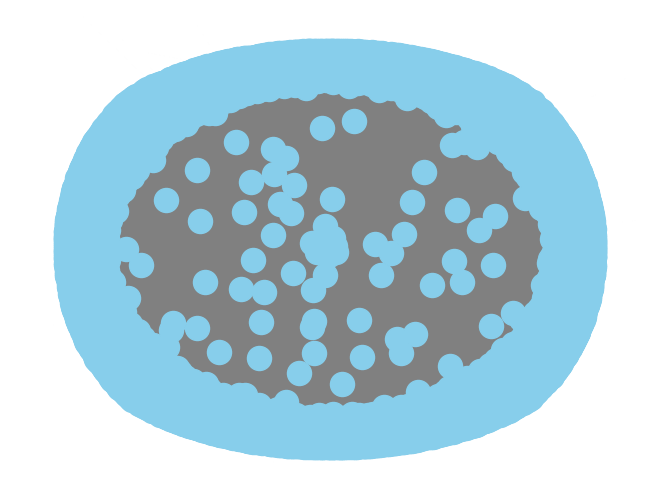

In [58]:
nx.draw(G, pos, node_color='skyblue', with_labels=False, edge_color='gray')

# Draw labels only for top N nodes
labels = {node: node for node in top_nodes}
nx.draw_networkx_nodes(G, pos, node_size=2, node_color='skyblue', alpha=0.7)
nx.draw_networkx_labels(G, pos, labels, font_size=2)
nx.draw_networkx_edges(G, pos, alpha=0.1)

plt.title("Graph with Labels for Top N Connected Nodes")
plt.axis('off')
plt.show()